In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
import os
import datetime
import joblib

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

def load_and_explore_data(file_path):
    try:
        # Load data
       df = pd.read_csv('/content/drive/My Drive/DATA-large.CSV (2).zip')

        # Display basic information
       print(f"Dataset shape: {df.shape}")
       print("\nFirst 5 rows:")
       print(df.head())
       print("\nData types:")
       print(df.dtypes)
       print("\nSummary statistics:")
       print(df.describe())
       print("\nMissing values:")
       print(df.isnull().sum())

       return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def preprocess_data(df):
    """Preprocess data for LSTM model"""
    # Check if there's a date/time column
    datetime_cols = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]

    # If a datetime column exists, set it as index
    if datetime_cols:
        datetime_col = datetime_cols[0]
        print(f"Converting {datetime_col} to datetime index")
        df[datetime_col] = pd.to_datetime(df[datetime_col])
        df = df.set_index(datetime_col)

    # Handle missing values (example: forward fill followed by backward fill)
    df = df.ffill().bfill()

    # Identify numeric columns for modeling
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    print(f"Numeric columns to be used for modeling: {numeric_cols}")

    # Scale the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[numeric_cols])
    scaled_df = pd.DataFrame(scaled_data, columns=numeric_cols, index=df.index)

    return scaled_df, scaler, numeric_cols

# Specify the path to your data file
file_path = 'DATA-large.CSV'

# Load and explore the data
df = load_and_explore_data(file_path)

# Preprocess the data
if df is not None:
    scaled_df, scaler, feature_columns = preprocess_data(df)
    print("\nScaled data preview:")
    print(scaled_df.head())


Dataset shape: (693220, 5)

First 5 rows:
                 time  temperature  humidity  pressure    lux
0   2022/3/12 22:32:2         24.2      32.7  98490.45  10.00
1   2022/3/12 22:32:6         24.0      33.9  98486.98  12.08
2  2022/3/12 22:32:11         24.1      33.9  98488.27  22.92
3  2022/3/12 22:32:16         24.1      33.8  98489.58  22.92
4  2022/3/12 22:32:21         24.1      35.0  98489.49  22.92

Data types:
time            object
temperature    float64
humidity       float64
pressure       float64
lux            float64
dtype: object

Summary statistics:
         temperature       humidity       pressure            lux
count  693220.000000  693220.000000  693220.000000  693220.000000
mean       22.202527      39.228161   98639.567843      28.361270
std         1.040201       4.068492     984.714168      55.275148
min        19.000000      29.300000   96352.680000       0.000000
25%        21.600000      36.300000   97974.167500       0.420000
50%        22.300000      3

In [4]:
def create_sequences(data, seq_length):
    """Create sequences for LSTM input"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def train_test_split_time_series(data, train_size=0.8):
    """Split the data into training and testing sets based on time"""
    n = len(data)
    train_data = data[:int(n * train_size)]
    test_data = data[int(n * train_size):]
    return train_data, test_data

# Set sequence length (lookback period)
seq_length = 60  # Use last 60 time steps to predict the next one

if 'scaled_df' in locals():
    # Split the data
    train_data, test_data = train_test_split_time_series(scaled_df)
    print(f"Training data shape: {train_data.shape}")
    print(f"Testing data shape: {test_data.shape}")

    # Create sequences
    X_train, y_train = create_sequences(train_data.values, seq_length)
    X_test, y_test = create_sequences(test_data.values, seq_length)

    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")

Training data shape: (554576, 4)
Testing data shape: (138644, 4)
X_train shape: (554516, 60, 4)
y_train shape: (554516, 4)
X_test shape: (138584, 60, 4)
y_test shape: (138584, 4)


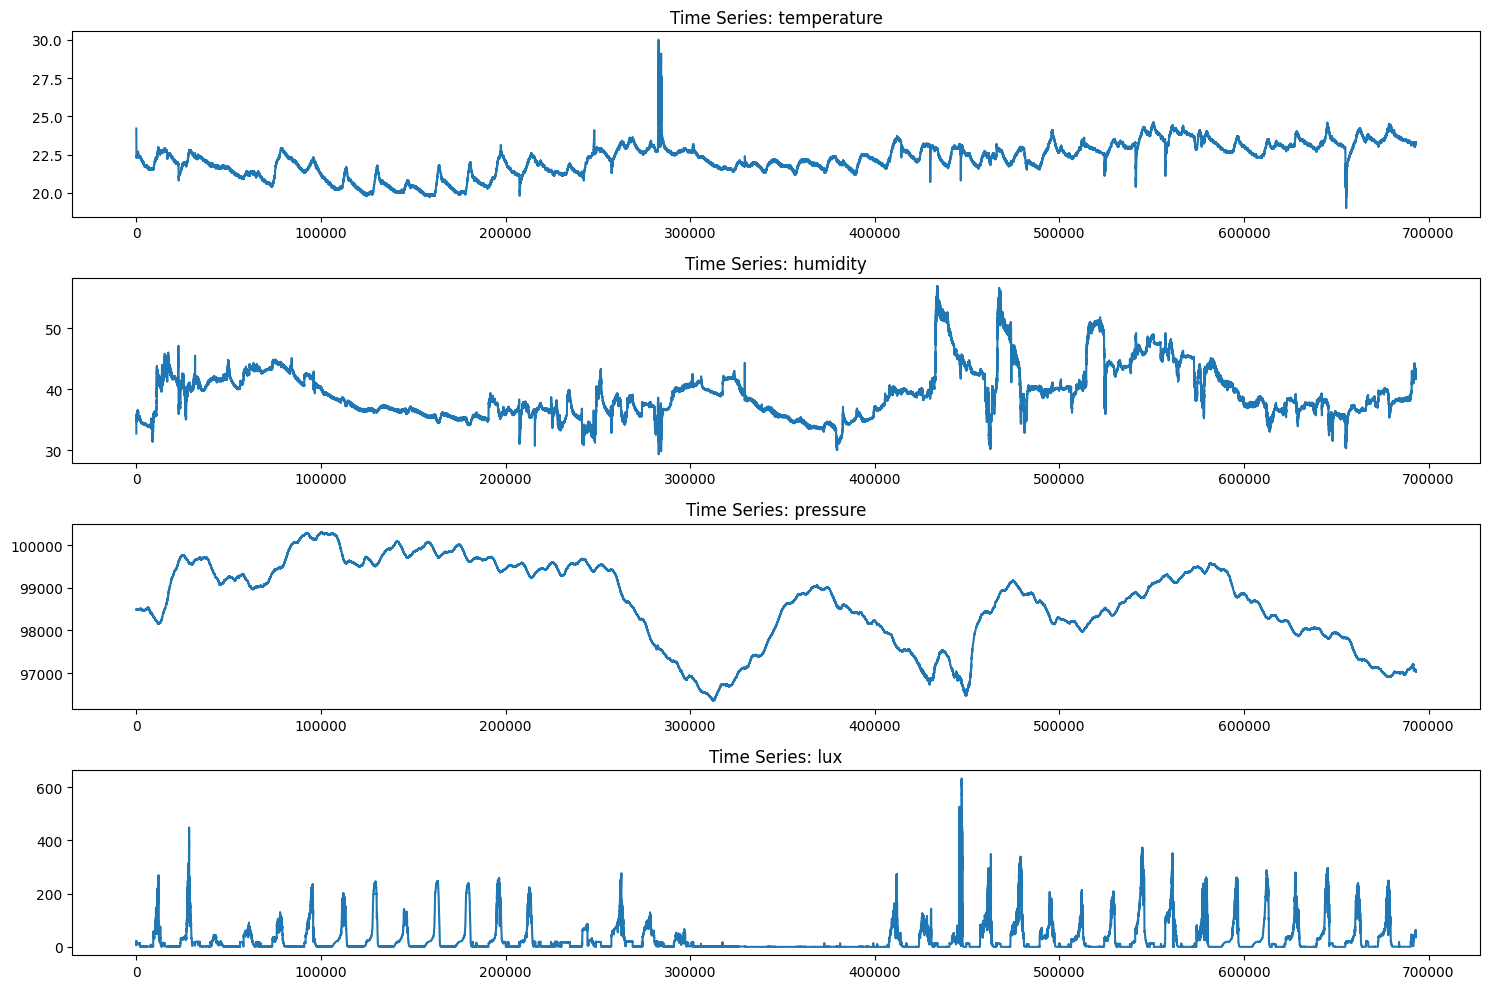

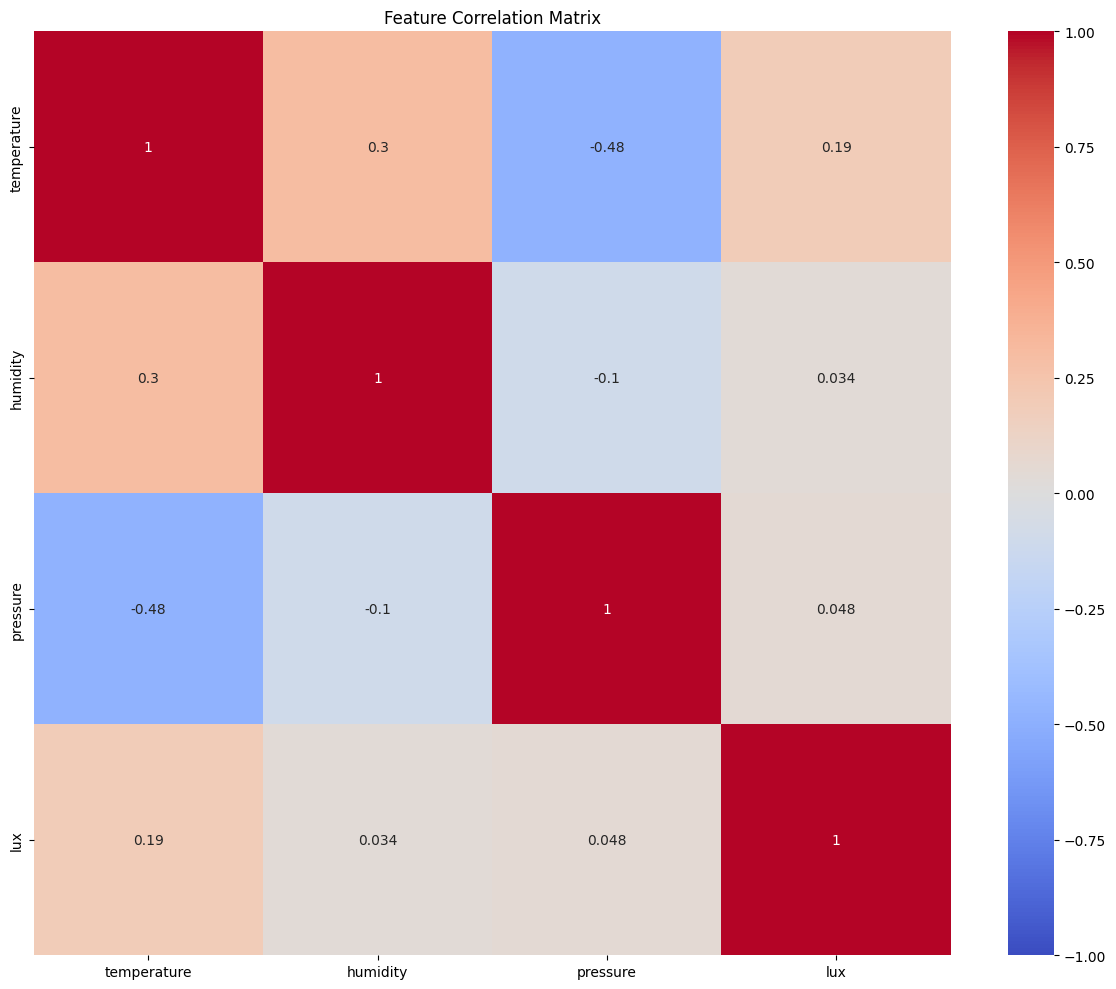

In [5]:
def visualize_original_data(df, columns=None, max_cols=5):
    """Visualize original time series data"""
    if columns is None:
        # If no specific columns provided, use all numeric columns
        columns = df.select_dtypes(include=[np.number]).columns.tolist()

    # Limit to max_cols to avoid too many plots
    columns = columns[:max_cols]

    plt.figure(figsize=(15, 10))
    for i, col in enumerate(columns, 1):
        plt.subplot(len(columns), 1, i)
        plt.plot(df.index, df[col])
        plt.title(f'Time Series: {col}')
        plt.tight_layout()

    plt.savefig('original_data_visualization.png')
    plt.show()

def visualize_correlation(df):
    """Visualize correlation between variables"""
    numeric_df = df.select_dtypes(include=[np.number])
    corr = numeric_df.corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()

    plt.savefig('correlation_matrix.png')
    plt.show()

# Visualize the original data
if 'df' in locals() and df is not None:
    visualize_original_data(df)
    visualize_correlation(df)

In [6]:
def build_lstm_model(input_shape, output_dim):
    """Build an LSTM model for multivariate time series prediction"""
    model = Sequential([
        # First LSTM layer with return sequences for stacking
        LSTM(100, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),

        # Second LSTM layer
        LSTM(80, activation='relu', return_sequences=False),
        Dropout(0.2),

        # Dense output layer
        Dense(output_dim)
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    print("Model Summary:")
    model.summary()

    return model

if 'X_train' in locals():
    # Build the model
    input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, num_features)
    output_dim = y_train.shape[1]  # Number of features to predict

    model = build_lstm_model(input_shape, output_dim)

Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 100)             │          42,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 80)                  │          57,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │             324 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,244 (391.58 KB)

 Trainable params: 100,244 (391.58 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
def train_lstm_model(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    """Train the LSTM model with callbacks for early stopping and checkpointing"""
    # Create directories for model checkpoints
    if not os.path.exists('models'):
        os.makedirs('models')

    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    model_checkpoint = ModelCheckpoint(
        filepath='models/lstm_model.h5',
        monitor='val_loss',
        save_best_only=True
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )

    return model, history

def evaluate_model(model, X_test, y_test, scaler, feature_columns):
    """Evaluate the model and calculate various performance metrics"""
    # Generate predictions
    predictions = model.predict(X_test)

    # Prepare arrays for inverse transform (if needed)
    y_test_reshaped = y_test.copy()
    predictions_reshaped = predictions.copy()

    # Calculate metrics on scaled data
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)

    # Calculate R² for each feature
    r2_scores = {}
    for i, feature in enumerate(feature_columns):
        r2 = r2_score(y_test[:, i], predictions[:, i])
        r2_scores[feature] = r2

    print("\nModel Performance Metrics (on scaled data):")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print("\nR² scores by feature:")
    for feature, score in r2_scores.items():
        print(f"{feature}: {score:.4f}")

    # Create a DataFrame with metrics for all features
    metrics_df = pd.DataFrame({
        'Feature': feature_columns,
        'R²': [r2_scores[feature] for feature in feature_columns],
        'RMSE': [np.sqrt(mean_squared_error(y_test[:, i], predictions[:, i])) for i in range(len(feature_columns))],
        'MAE': [mean_absolute_error(y_test[:, i], predictions[:, i]) for i in range(len(feature_columns))]
    })

    return predictions, metrics_df

# Train the model
if 'model' in locals() and 'X_train' in locals():
    model, history = train_lstm_model(model, X_train, y_train, X_test, y_test, epochs=10)

    # Evaluate the model
    predictions, metrics_df = evaluate_model(model, X_test, y_test, scaler, feature_columns)
    print("\nPerformance metrics by feature:")
    print(metrics_df)

    # Save the model and scaler for later use
    joblib.dump(scaler, 'models/scaler.pkl')


Epoch 1/10
17329/17329 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0021 - mae: 0.0273

17329/17329 ━━━━━━━━━━━━━━━━━━━━ 1625s 94ms/step - loss: 0.0021 - mae: 0.0273 - val_loss: 2.3444e-04 - val_mae: 0.0107
Epoch 2/10
17329/17329 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 6.1839e-04 - mae: 0.0168

17329/17329 ━━━━━━━━━━━━━━━━━━━━ 1637s 93ms/step - loss: 6.1839e-04 - mae: 0.0168 - val_loss: 1.0831e-04 - val_mae: 0.0074
Epoch 3/10
17329/17329 ━━━━━━━━━━━━━━━━━━━━ 1646s 93ms/step - loss: 5.9539e-04 - mae: 0.0163 - val_loss: 1.3746e-04 - val_mae: 0.0085
Epoch 4/10
17329/17329 ━━━━━━━━━━━━━━━━━━━━ 1588s 92ms/step - loss: 5.7986e-04 - mae: 0.0160 - val_loss: 0.0329 - val_mae: 0.0109
Epoch 5/10
17329/17329 ━━━━━━━━━━━━━━━━━━━━ 1666s 93ms/step - loss: 5.7191e-04 - mae: 0.0159 - val_loss: 620.5071 - val_mae: 0.1461
Epoch 6/10
17329/17329 ━━━━━━━━━━━━━━━━━━━━ 1615s 93ms/step - loss: 5.6387e-04 - mae: 0.0157 - val_loss: 1.1179e-04 - val_mae: 0.0078
Epoch 7/10
17329/17329 ━━━━━━━━━━━━━━━━━━━━ 1613s 93ms/step - loss: 5.5858e-04 - mae: 0.0157 - val_loss: 1.3387e-04 - val_mae: 0.0082
Epoch 8/10
17329/17329 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 5.5504e-04 - mae: 0.0156

17329/17329 ━━━━━━━━━━━━━━━━━━━━ 1614s 93ms/step - loss: 5.5504e-04 - mae: 0.0156 - val_loss: 1.0246e-04 - val_mae: 0.0070
Epoch 9/10
17329/17329 ━━━━━━━━━━━━━━━━━━━━ 1609s 91ms/step - loss: 5.5406e-04 - mae: 0.0156 - val_loss: 1.1712e-04 - val_mae: 0.0072
Epoch 10/10
17329/17329 ━━━━━━━━━━━━━━━━━━━━ 1613s 93ms/step - loss: 5.5265e-04 - mae: 0.0155 - val_loss: 3961626.7500 - val_mae: 15.0807
4331/4331 ━━━━━━━━━━━━━━━━━━━━ 119s 27ms/step

Model Performance Metrics (on scaled data):
MSE: 0.0001
RMSE: 0.0101
MAE: 0.0070

R² scores by feature:
temperature: 0.9521
humidity: 0.9910
pressure: 0.9983
lux: 0.9909

Performance metrics by feature:
       Feature        R²      RMSE       MAE
0  temperature  0.952106  0.010352  0.007547
1     humidity  0.990996  0.011257  0.009159
2     pressure  0.998331  0.008825  0.005633
3          lux  0.990922  0.009902  0.005842


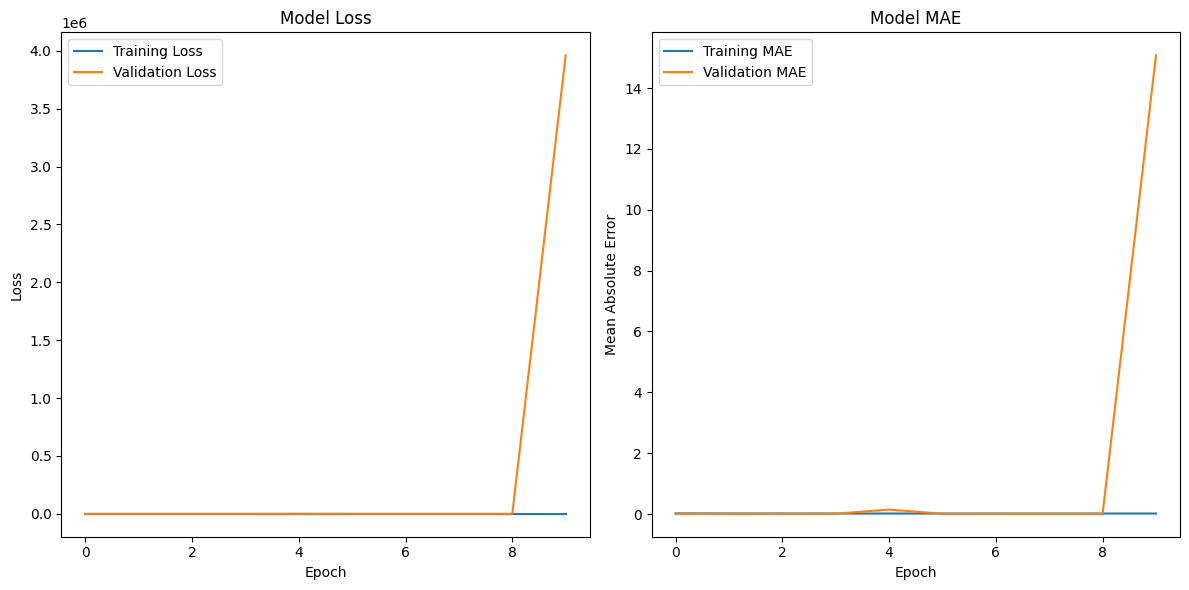

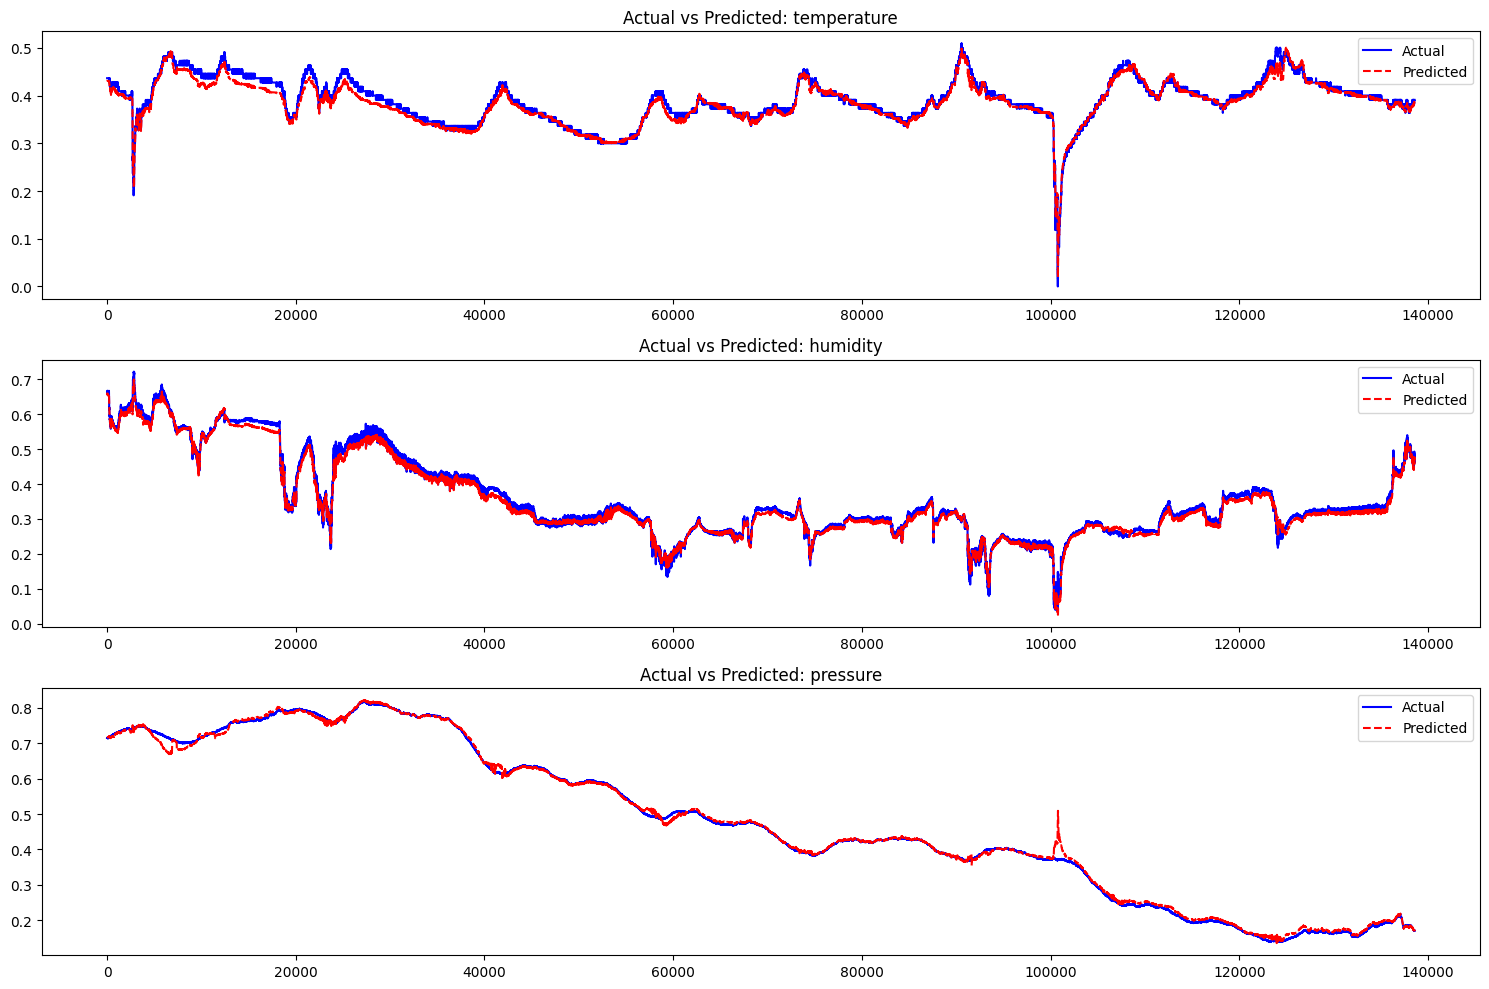

In [8]:
def plot_training_history(history):
    """Plot training and validation loss"""
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def plot_predictions(test_data, predictions, seq_length, feature_columns, max_features=3):
    """Plot actual vs predicted values for selected features"""
    # Get the actual values
    actual_values = test_data.values[seq_length:]

    # Select a few features to visualize (to avoid cluttering)
    selected_features = feature_columns[:min(max_features, len(feature_columns))]
    feature_indices = [feature_columns.index(feature) for feature in selected_features]

    plt.figure(figsize=(15, 10))
    for i, feature_idx in enumerate(feature_indices):
        plt.subplot(len(feature_indices), 1, i+1)

        # Plot actual values
        plt.plot(actual_values[:, feature_idx], label='Actual', color='blue')

        # Plot predicted values
        plt.plot(predictions[:, feature_idx], label='Predicted', color='red', linestyle='--')

        plt.title(f'Actual vs Predicted: {selected_features[i]}')
        plt.legend()

    plt.tight_layout()
    plt.savefig('prediction_results.png')
    plt.show()

# Plot training history and predictions
if 'history' in locals() and 'predictions' in locals():
    plot_training_history(history)
    plot_predictions(test_data, predictions, seq_length, feature_columns)


In [9]:
def predict_for_date(model, scaler, seq_length, feature_columns, df, target_date, time_steps_ahead=1):
    """
    Make predictions for a specific future date or time

    Parameters:
    - model: Trained LSTM model
    - scaler: Fitted MinMaxScaler
    - seq_length: Sequence length used for training
    - feature_columns: List of feature column names
    - df: Original DataFrame with datetime index
    - target_date: Target date for prediction (string in format 'YYYY-MM-DD' or 'YYYY-MM-DD HH:MM:SS')
    - time_steps_ahead: How many steps into the future to predict

    Returns:
    - Predicted values for the target date
    """
    try:
        # Convert target_date to datetime if it's a string
        if isinstance(target_date, str):
            target_date = pd.to_datetime(target_date)

        # Check if the date is in the future
        latest_date = df.index.max()

        if target_date <= latest_date:
            print(f"Warning: Target date {target_date} is not in the future. Latest date in data is {latest_date}")
            print("Will use the most recent sequence for prediction.")

        # Get the most recent sequence of data
        recent_data = df[feature_columns].values[-seq_length:]

        # Scale the data
        scaled_recent_data = scaler.transform(recent_data)

        # Reshape for LSTM input [samples, time steps, features]
        input_sequence = scaled_recent_data.reshape(1, seq_length, len(feature_columns))

        # Make prediction for the next time step
        predicted_scaled = model.predict(input_sequence)

        # For multiple steps ahead
        current_sequence = scaled_recent_data
        all_predictions = []

        for _ in range(time_steps_ahead):
            # Reshape current sequence
            current_sequence_reshaped = current_sequence.reshape(1, seq_length, len(feature_columns))

            # Predict next step
            next_step = model.predict(current_sequence_reshaped)[0]
            all_predictions.append(next_step)

            # Update sequence by removing the first step and adding the new prediction
            current_sequence = np.vstack([current_sequence[1:], next_step])

        # Convert the predictions back to original scale
        predicted_values = [scaler.inverse_transform(pred.reshape(1, -1))[0] for pred in all_predictions]

        # Create a DataFrame for the predictions
        time_index = [latest_date + pd.Timedelta(days=i+1) for i in range(time_steps_ahead)]
        predictions_df = pd.DataFrame(predicted_values, index=time_index, columns=feature_columns)

        return predictions_df

    except Exception as e:
        print(f"Error making prediction: {e}")
        return None

# Example of using the prediction function
def predict_interactive():
    """Interactive function for user to input date and get predictions"""
    # Load the model and scaler
    try:
        model = load_model('models/lstm_model.h5')
        scaler = joblib.load('models/scaler.pkl')

        # Get user input
        date_str = input("Enter target date (YYYY-MM-DD or YYYY-MM-DD HH:MM:SS): ")
        steps_ahead = int(input("How many time steps ahead to predict (1-30): "))

        if steps_ahead < 1 or steps_ahead > 30:
            print("Steps ahead must be between 1 and 30. Setting to 1.")
            steps_ahead = 1

        # Make prediction
        predictions = predict_for_date(
            model=model,
            scaler=scaler,
            seq_length=seq_length,
            feature_columns=feature_columns,
            df=df,
            target_date=date_str,
            time_steps_ahead=steps_ahead
        )

        if predictions is not None:
            print("\nPredictions:")
            print(predictions)

            # Visualize predictions
            plt.figure(figsize=(15, 10))
            for i, col in enumerate(predictions.columns[:5], 1):  # Show first 5 features
                plt.subplot(min(5, len(predictions.columns)), 1, i)
                plt.plot(predictions.index, predictions[col])
                plt.title(f'Predicted {col}')
                plt.tight_layout()

            plt.savefig('future_predictions.png')
            plt.show()

            return predictions

    except Exception as e:
        print(f"Error in interactive prediction: {e}")
        return None

# Add this to the main script
if 'model' in locals() and 'scaler' in locals():
    print("\nModel and scaler are ready for prediction!")
    print("You can use the predict_interactive() function to make predictions for specific dates.")



Model and scaler are ready for prediction!
You can use the predict_interactive() function to make predictions for specific dates.


def main():
    """Main function to run the entire pipeline"""
    print("LSTM Time Series Prediction Pipeline")
    print("===================================")
    
    # Step 1: Load and preprocess data
    file_path = input("Enter the path to your CSV file: ")
    df = load_and_explore_data(file_path)
    
    if df is None:
        print("Failed to load data. Exiting.")
        return
    
    # Step 2: Preprocess data
    scaled_df, scaler, feature_columns = preprocess_data(df)
    
    # Step 3: Visualize original data
    visualize_original_data(df)
    visualize_correlation(df)
    
    # Step 4: Create sequences
    seq_length = int(input("Enter sequence length (recommended: 30-60): "))
    train_data, test_data = train_test_split_time_series(scaled_df)
    X_train, y_train = create_sequences(train_data.values, seq_length)
    X_test, y_test = create_sequences(test_data.values, seq_length)
    
    # Step 5: Build and train model
    input_shape = (X_train.shape[1], X_train.shape[2])
    output_dim = y_train.shape[1]
    model = build_lstm_model(input_shape, output_dim)
    
    epochs = int(input("Enter number of training epochs (recommended: 50-200): "))
    batch_size = int(input("Enter batch size (recommended: 16-64): "))
    
    model, history = train_lstm_model(model, X_train, y_train, X_test, y_test, epochs, batch_size)
    
    # Step 6: Evaluate model
    predictions, metrics_df = evaluate_model(model, X_test, y_test, scaler, feature_columns)
    
    # Step 7: Visualize results
    plot_training_history(history)
    plot_predictions(test_data, predictions, seq_length, feature_columns)
    
    # Step 8: Save model and scaler
    if not os.path.exists('models'):
        os.makedirs('models')
    model.save('models/lstm_model.h5')
    joblib.dump(scaler, 'models/scaler.pkl')
    
    # Step 9: Interactive prediction
    while True:
        choice = input("\nDo you want to make predictions for a specific date? (y/n): ")
        if choice.lower() != 'y':
            break
        
        predict_interactive()
    
    print("\nThank you for using the LSTM Time Series Prediction Pipeline!")

if __name__ == "__main__":
    main()

LSTM Time Series Prediction Pipeline
Enter the path to your CSV file: /content/drive/My Drive/DATA-large.CSV (2).zip
Dataset shape: (693220, 5)

First 5 rows:
                 time  temperature  humidity  pressure    lux
0   2022/3/12 22:32:2         24.2      32.7  98490.45  10.00
1   2022/3/12 22:32:6         24.0      33.9  98486.98  12.08
2  2022/3/12 22:32:11         24.1      33.9  98488.27  22.92
3  2022/3/12 22:32:16         24.1      33.8  98489.58  22.92
4  2022/3/12 22:32:21         24.1      35.0  98489.49  22.92

Data types:
time            object
temperature    float64
humidity       float64
pressure       float64
lux            float64
dtype: object

Summary statistics:
         temperature       humidity       pressure            lux
count  693220.000000  693220.000000  693220.000000  693220.000000
mean       22.202527      39.228161   98639.567843      28.361270
std         1.040201       4.068492     984.714168      55.275148
min        19.000000      29.300000   9635

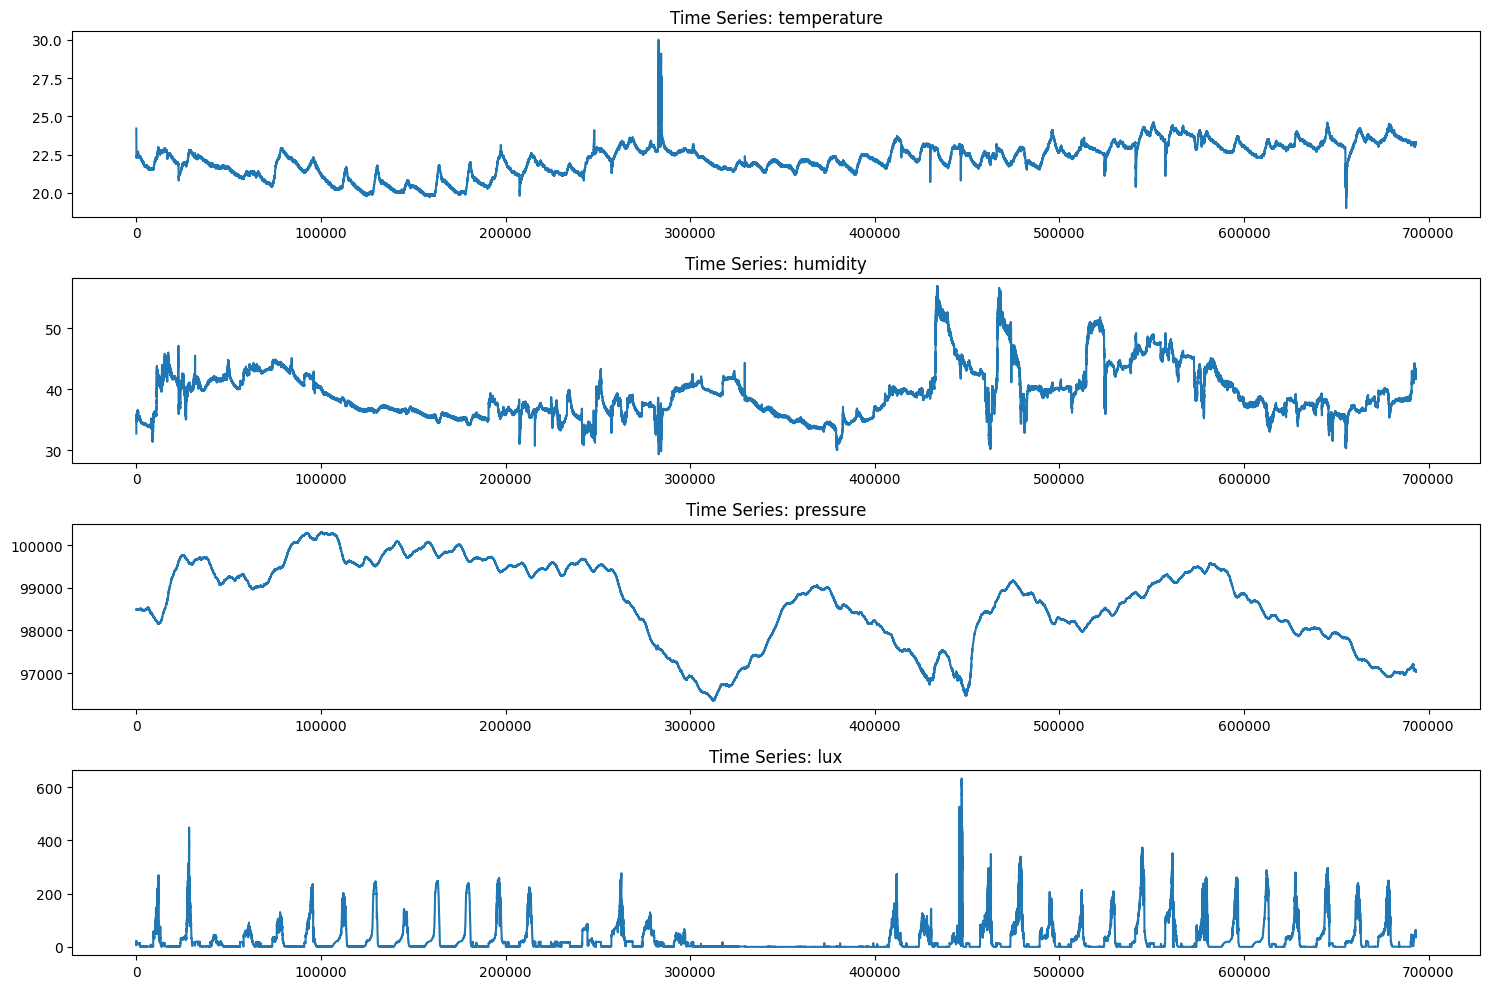

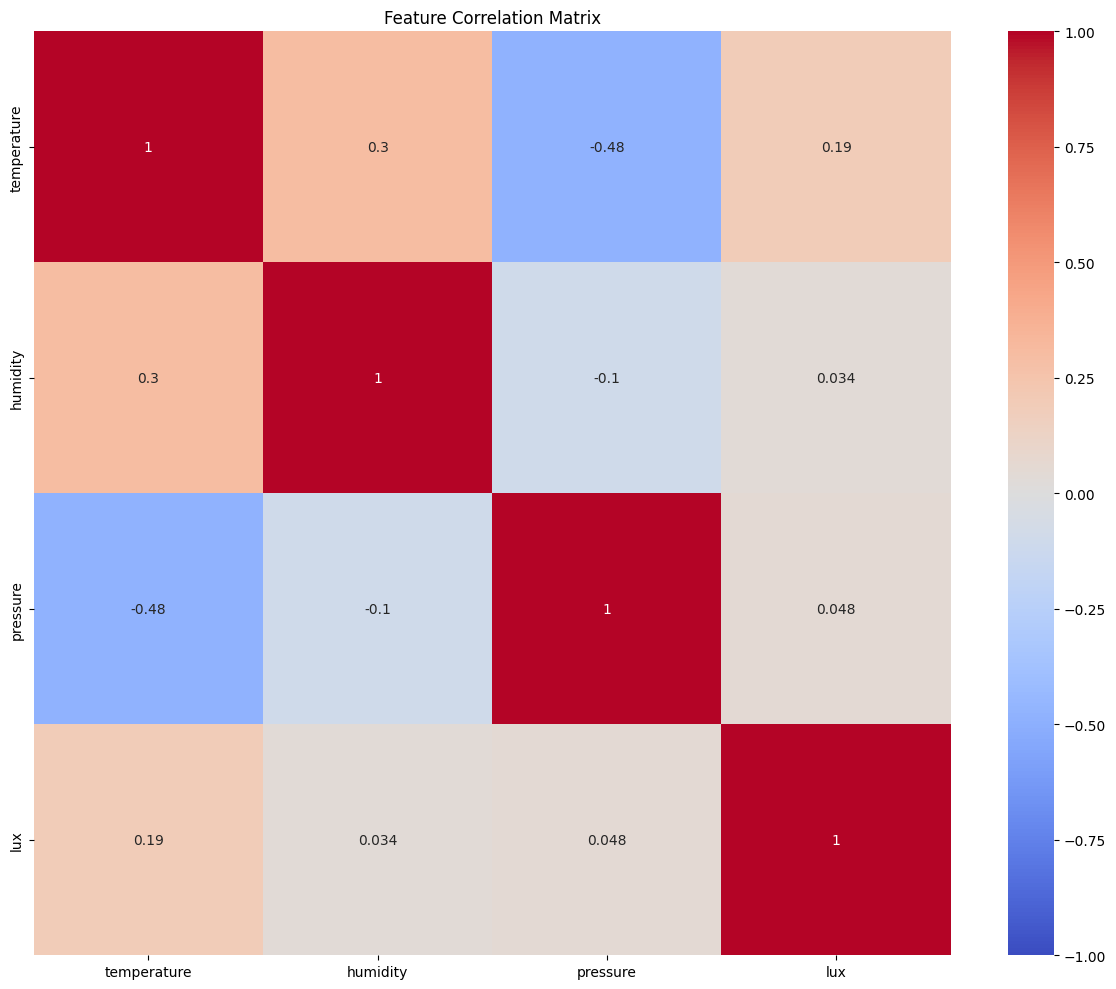

Enter sequence length (recommended: 30-60): 3
Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 3, 100)              │          42,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 80)                  │          57,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             324 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,244 (391.58 KB)

 Trainable params: 100,244 (391.58 KB)

 Non-trainable params: 0 (0.00 B)

Enter number of training epochs (recommended: 50-200): 1
Enter batch size (recommended: 16-64): 16
34660/34661 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - mae: 0.0262

34661/34661 ━━━━━━━━━━━━━━━━━━━━ 298s 8ms/step - loss: 0.0021 - mae: 0.0262 - val_loss: 1.8410e-04 - val_mae: 0.0096
4333/4333 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step

Model Performance Metrics (on scaled data):
MSE: 0.0002
RMSE: 0.0136
MAE: 0.0096

R² scores by feature:
temperature: 0.9312
humidity: 0.9947
pressure: 0.9924
lux: 0.9860


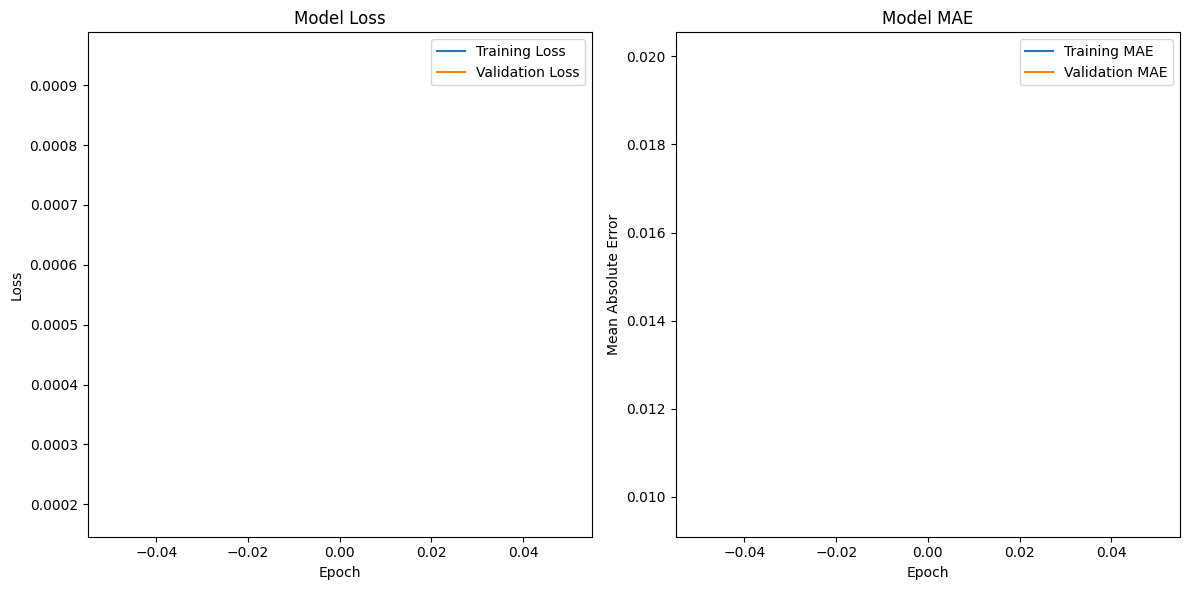

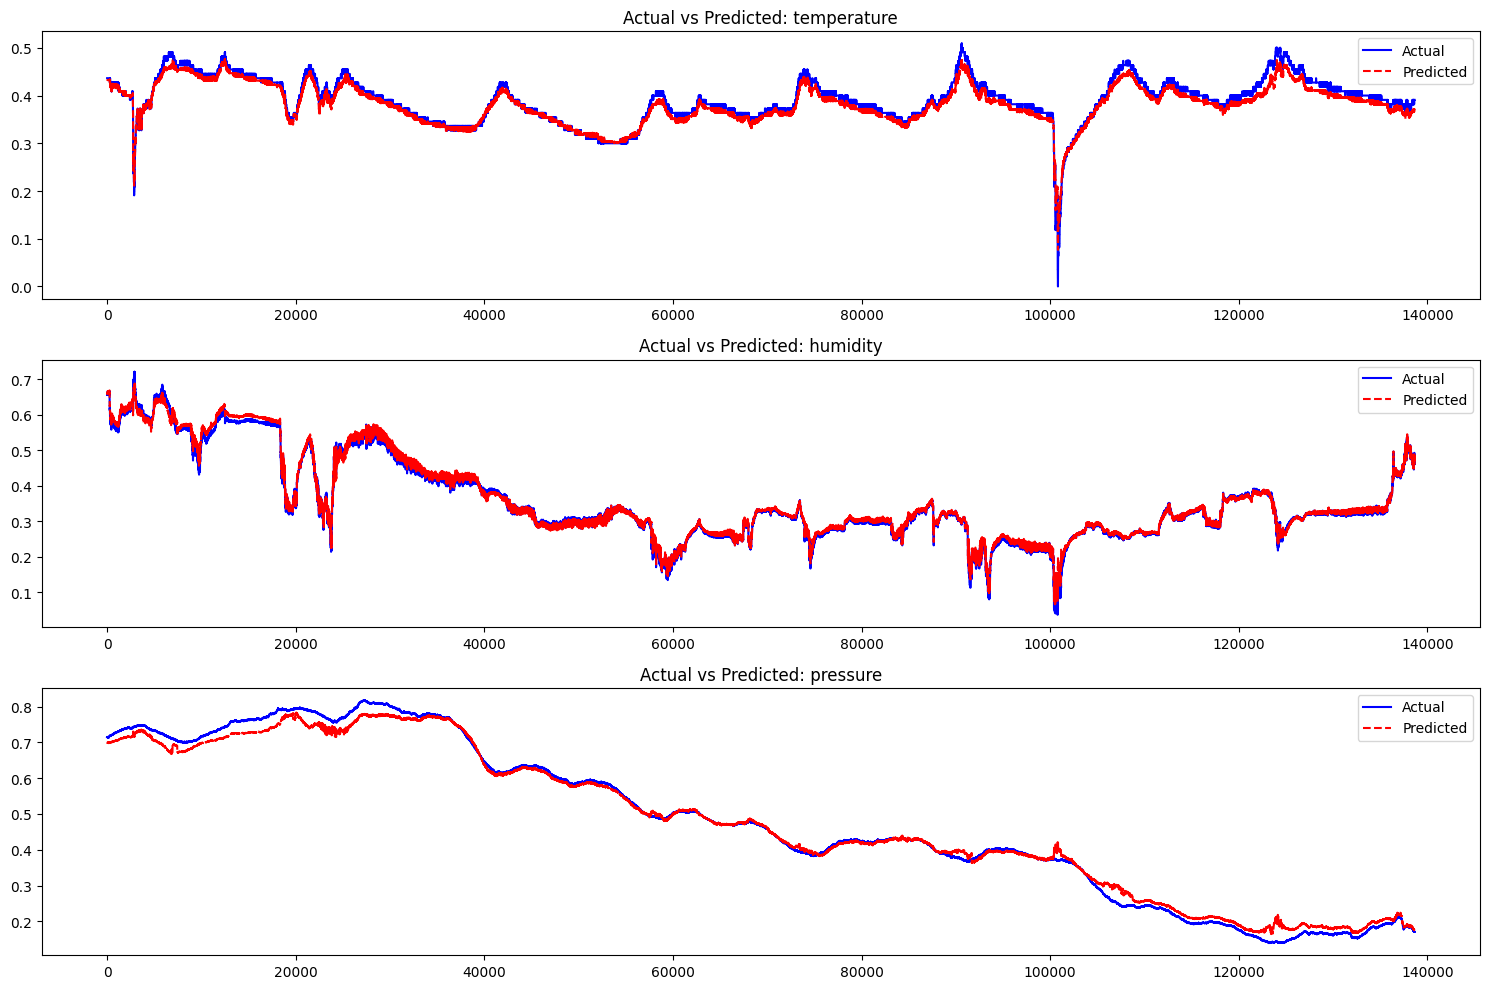


Do you want to make predictions for a specific date? (y/n): y
Error in interactive prediction: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}

Do you want to make predictions for a specific date? (y/n): y
Error in interactive prediction: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}

Do you want to make predictions for a specific date? (y/n): n

Thank you for using the LSTM Time Series Prediction Pipeline!


In [10]:
def main():
    """Main function to run the entire pipeline"""
    print("LSTM Time Series Prediction Pipeline")
    print("===================================")

    # Step 1: Load and preprocess data
    file_path = input("Enter the path to your CSV file: ")
    df = load_and_explore_data(file_path)

    if df is None:
        print("Failed to load data. Exiting.")
        return

    # Step 2: Preprocess data
    scaled_df, scaler, feature_columns = preprocess_data(df)

    # Step 3: Visualize original data
    visualize_original_data(df)
    visualize_correlation(df)

    # Step 4: Create sequences
    seq_length = int(input("Enter sequence length (recommended: 30-60): "))
    train_data, test_data = train_test_split_time_series(scaled_df)
    X_train, y_train = create_sequences(train_data.values, seq_length)
    X_test, y_test = create_sequences(test_data.values, seq_length)

    # Step 5: Build and train model
    input_shape = (X_train.shape[1], X_train.shape[2])
    output_dim = y_train.shape[1]
    model = build_lstm_model(input_shape, output_dim)

    epochs = int(input("Enter number of training epochs (recommended: 50-200): "))
    batch_size = int(input("Enter batch size (recommended: 16-64): "))

    model, history = train_lstm_model(model, X_train, y_train, X_test, y_test, epochs, batch_size)

    # Step 6: Evaluate model
    predictions, metrics_df = evaluate_model(model, X_test, y_test, scaler, feature_columns)

    # Step 7: Visualize results
    plot_training_history(history)
    plot_predictions(test_data, predictions, seq_length, feature_columns)

    # Step 8: Save model and scaler
    if not os.path.exists('models'):
        os.makedirs('models')
    model.save('models/lstm_model.h5')
    joblib.dump(scaler, 'models/scaler.pkl')

    # Step 9: Interactive prediction
    while True:
        choice = input("\nDo you want to make predictions for a specific date? (y/n): ")
        if choice.lower() != 'y':
            break

        predict_interactive()

    print("\nThank you for using the LSTM Time Series Prediction Pipeline!")

if __name__ == "__main__":
    main()